#### This notebook runs experiments with various sinusoidal forcings to simulate interannual/interdecadal surface variability 
#### and to analyse its effects on global ocean heat content.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import TwoSlopeNorm
import cmocean as cm
from scipy.optimize import curve_fit

## The model

Consider the following modification to the heat equation:

$$
\frac{\partial T}{\partial t} = \frac{\partial}{\partial z} \bigg(\kappa \frac{\partial T}{\partial z}\bigg) + \bigg(\frac{Q(t)}{\rho_0 c_p z_m} - \gamma\big(T - (T_i(z) + T_0)\big) \bigg) \times H(z_m - z) - \mu \big(T - T_i(z) \big) \times H(z - z_d) + \text{C.A.},$$ 

where $T = T(t, z)$ is the temperature (MAKE A NOTE OF WHETHER WE THINK OF THIS AS POTENTIAL, CONSERVATIVE, IN SITU, ETC.); $\kappa$ is the (constant) diffusivity; $Q(t)$ is a prescribed, time-dependent surface heat flux; $\rho_0 = 1025$ kg m$^{-3}$ is the reference density; $c_p = 4000$ J/(kg C) is the specific heat capacity; $z_m$ is the depth of the mix*ing* layer (i.e., a minimum mixed layer); $\gamma$ is a damping term (acting like a climate feedback parameter) which acts to restore the surface back to some initial state $T_i(z)$. The term $T_0$ is applied in perturbations to perturb the surface temperature (like an air temperature perturbation). The $H$ represents a Heaviside function to denote that this forcing and restoring is applied over the minimum mixing layer. The next term is a deep ocean restoring term which acts to balance the surface restoring at the surface. This is so that the steady-state solution is not simply a profile of constant temperature equal to the surface temperature. The paramater $\mu$ is a characteristic timescale over which the temperature profile is relaxed back to its initial profile $T_i(z)$ in the deep ocean (e.g., 20 years), applied only below some prescribed depth $z_d$ (e.g., $z_d = 900$m).

Finally, the term 'C.A.' denotes a convective adjustment algorithm, following _Rahmstorf (1993)_, which checks at each timestep whether any convective instabilities arise and removes them conservatively.

_Make a note of the initial and boundary conditions._

We will write a forward-time, central-space finite difference scheme for this initial-boundary value problem. I have also solved analytically for the steady-state solution, which can be found in an Appendeix to the thesis.

In [2]:
# Constants, data, parameters...

rho = 1025 # kg/m^3
c = 4000 # J/(kg C)

z_m = 50.0 # Depth of minimum mixing layer
z_d = 900.0 # Depth for deep ocean restoring term
z_b = 1000.0 # Depth of thermocline

mu = 1/(50 * 365 * 86400) # Deep ocean restoring time scale
gamma = 1/(0.7 * 365 * 86400) # Surface restoring time scale (to be determined through my least squares regression)
kappa = 1e-6 # Diffusivity, m/s^2

T_0 = 22.0 # Top temperature for initial condition
T_b = 5.0 # Bottom temperature for initial condition (this warms up a bit during runs because of the no-flux at bottom condition)

dt = 10.0 * 86400 # units: s
dz = 5.0 # units: m

z = np.linspace(0.0, z_b, int(z_b / dz) + 1) # Depth at top/bottom of grid cell
z_t = (z[1:] + z[:-1]) / 2 # Depth at the middle of grid cell

In [3]:
# Initial condition: constant in mixing layer, linearly stratified elsewhere

def initial_condition(z_t):
    mixing_index = (np.abs(z_t - z_m)).argmin() # Index in z_t exactly dz/2 m above z_m.
    mixing_layer = T_0 * np.ones(mixing_index + 1)
    z_t = z_t[mixing_index + 1:]
    thermocline = ((T_0 - T_b) * z_t - (T_0 * z_b - T_b * z_m)) / (z_m - z_b)
    return np.concatenate((mixing_layer, thermocline), axis = None)

T_i = initial_condition(z_t)

In [4]:
### Intermediate functions

def convective_adjustment(T, z_m):
        
    def mixing_Rahmstorf(T):
        
        for i in range(len(T) - 1):
            
            if T[i] < T[i + 1]:
                
                j = 0
                
                # This loop mixes the instability downwards
                
                while T[i + j] < T[i + j + 1]:
                    
                    T[i : i + j + 2] = np.mean(T[i : i + j + 2])
                    
                    j += 1
                    
                break
            
        return T
    
    
    # Run the Rahmstorf mixing algorithm until the instability has been eliminated from the water column (i.e., from the mixing layer) 
    
    for k in range(int(z_m / dz) + 1):
        
        mixing_Rahmstorf(T)
    
    return mixing_Rahmstorf(T)



### Ocean heat content

def OHC(T):
    
    OHC = np.empty(T.shape[1])
    
    for i in range(len(OHC)):
        
#         OHC[i] = rho * c * np.cumsum(T[: , i])[- 1] * dz # This is for ocean heat content
        
        OHC[i] = np.mean(T[:, i]) # This is for average temperature
        
    return OHC    

In [5]:
### The forward-in-time, central-in-space scheme with restoring and flux boundary conditions ###

def model(dt, dz, z_m, z_d, z_b, kappa, lambd, T_initial, Q, T0, years):
    
    # Data
    
    days = dt / 86400 # Timestep in days
    M = int(z_b / dz) # Number of spatial steps evaluated at the top/bottom of the grid cell
    N = int(years * 360 / days) # Number of timesteps in days (taking 1 year = 360 days)
    z = np.linspace(0.0, z_b, M + 1) # Depth at top/bottom of grid cell
    z_t = (z[1:] + z[:-1]) / 2 # Depth at the middle of grid cell 
    t = np.linspace(0.0, years * 360, N + 1)
    Hdeep = np.heaviside(z - z_d, 1)
    radiative_forcing = Q / (c * rho * z_m)
    
    # Paramaterisation for how the mixed layer depth shoals
    
    Q_optimal = 2.0 # from least squares analysis, cf. one_dim_experiments notebook
    dQ = np.diff(Q) # proportional to dQ/dt 
    dzm_optimal = - z_m * 0.05 # i.e., the optimal Q warming occurred with a simultaneous MLD shoaling of 5%
    dzm = dQ / Q_optimal * dzm_optimal
    
    # Temperature and flux matrices. Prescribe initial and boundary conditions
    
    T = np.zeros((M, N + 1)) # i.e. evaluated at the middle of grid cell
    F = np.zeros((M + 1, N + 1)) # i.e. evaluated at the top/bottom of grid cell
    
    T[:, 0] = T_initial # Initial condition
    F[0, :] = 0 # No flux at surface
    F[- 1, :] = 0 # No flux at base
        
    k = 1 # proportionality counter for how much MLD shoals; is multipled by gamma and z_m wherever they occur.
    for n in range(0, N):
        
        #k = k + dzm[n] / z_m
    
        for m in range(1, M):
            
            F[m, n] = kappa / dz * (T[m - 1, n] - T[m, n])
            
        for m in range(0, M):
             
            T[m, n + 1] = T[m, n] + dt / dz * (F[m, n] - F[m + 1, n]) \
            + dt * (radiative_forcing[n + 1] - k * gamma * (T[m, n] - (T0[n + 1] + T[m, 0]))) * np.heaviside(k * z_m - z, 0)[m]  \
            - dt * mu * (T[m, n] - T[m, 0]) * Hdeep[m]
            
            # np.heaviside(z_m - z, 0): 1 above z = z_m, 0 elsewhere
            # np.heaviside(z - z_d, 1): 1 below z = z_d, 0 elsewhere
            
        #Convective adjustment step
    
        convective_adjustment(T[:, n + 1], k * z_m)
        
    return T

### Define forcings

In [7]:
years = 100
days = dt / 86400
N = int(years * 360 / days)
t = np.linspace(0.0, years * 360, N + 1)

def sin(amp, period):
    period_day = period * 360
    return amp * np.sin((2 * np.pi / period_day) * t)

Q = 8.0
T0 = 1.0

### Run model

In [33]:
# Control

lambd = Q / (1.2 - 1.0)
gamma = lambd / (rho*c*z_m)
kappa = 5e-6

Q_cont = np.zeros(int(years * 360 / days) + 1)
T0_cont = np.zeros(int(years * 360 / days) + 1)
T_cont = model(dt, dz, z_m, z_d, z_b, kappa, gamma, T_i, Q_cont, T0_cont, years)

# Variable forcing

periods = [2.0, 5.0, 7.0, 10.0, 12.0, 16.0, 20.0]

T_A1_P2 = model(dt, dz, z_m, z_d, z_b, kappa, gamma, T_i, sin(Q, periods[0]), sin(T0, periods[0]), years)
T_A1_P5 = model(dt, dz, z_m, z_d, z_b, kappa, gamma, T_i, sin(Q, periods[1]), sin(T0, periods[1]), years)
T_A1_P7 = model(dt, dz, z_m, z_d, z_b, kappa, gamma, T_i, sin(Q, periods[2]), sin(T0, periods[2]), years)
T_A1_P10 = model(dt, dz, z_m, z_d, z_b, kappa, gamma, T_i, sin(Q, periods[3]), sin(T0, periods[3]), years)
T_A1_P12 = model(dt, dz, z_m, z_d, z_b, kappa, gamma, T_i, sin(Q, periods[4]), sin(T0, periods[4]), years)
T_A1_P16 = model(dt, dz, z_m, z_d, z_b, kappa, gamma, T_i, sin(Q, periods[5]), sin(T0, periods[5]), years)
T_A1_P20 = model(dt, dz, z_m, z_d, z_b, kappa, gamma, T_i, sin(Q, periods[6]), sin(T0, periods[6]), years)

In [78]:
(OHCs[2] - OHCs[0])[P * i * 36 : P*(i+1) * 36 - P + 1].shape, OHCs[2].shape

((176,), (3601,))

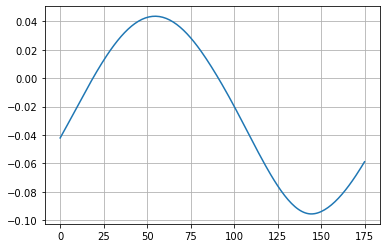

In [76]:
i = 1
P = 5
plt.plot((OHCs[2] - OHCs[0])[P * i * 36 : P*(i+1) * 36 - P + 1])
plt.grid()
# plt.plot((OHCs[1] - OHCs[0])[:400])

In [61]:
days = dt / 86400
timesteps = T_cont.shape[1]
length = (timesteps - 1) * days / 360
time_years = np.linspace(0, length, timesteps)

#Calculate ocean heat content (or global mean temperature)
temps = [T_cont,
         T_A1_P2,
        T_A1_P5,
        T_A1_P7,
        T_A1_P10,
        T_A1_P12,
        T_A1_P16,
        T_A1_P20]

OHCs = [OHC(temps[i]) for i in range(len(temps))]


OHCs_ave_over_period = [np.mean((OHCs[j] - OHCs[0])[periods[j] * i * 36 : P * (i + 1) * 36]) for i in range(len()) for j in range(1, len(periods[j]))]

TypeError: len() takes exactly one argument (0 given)

In [ ]:
# Average 

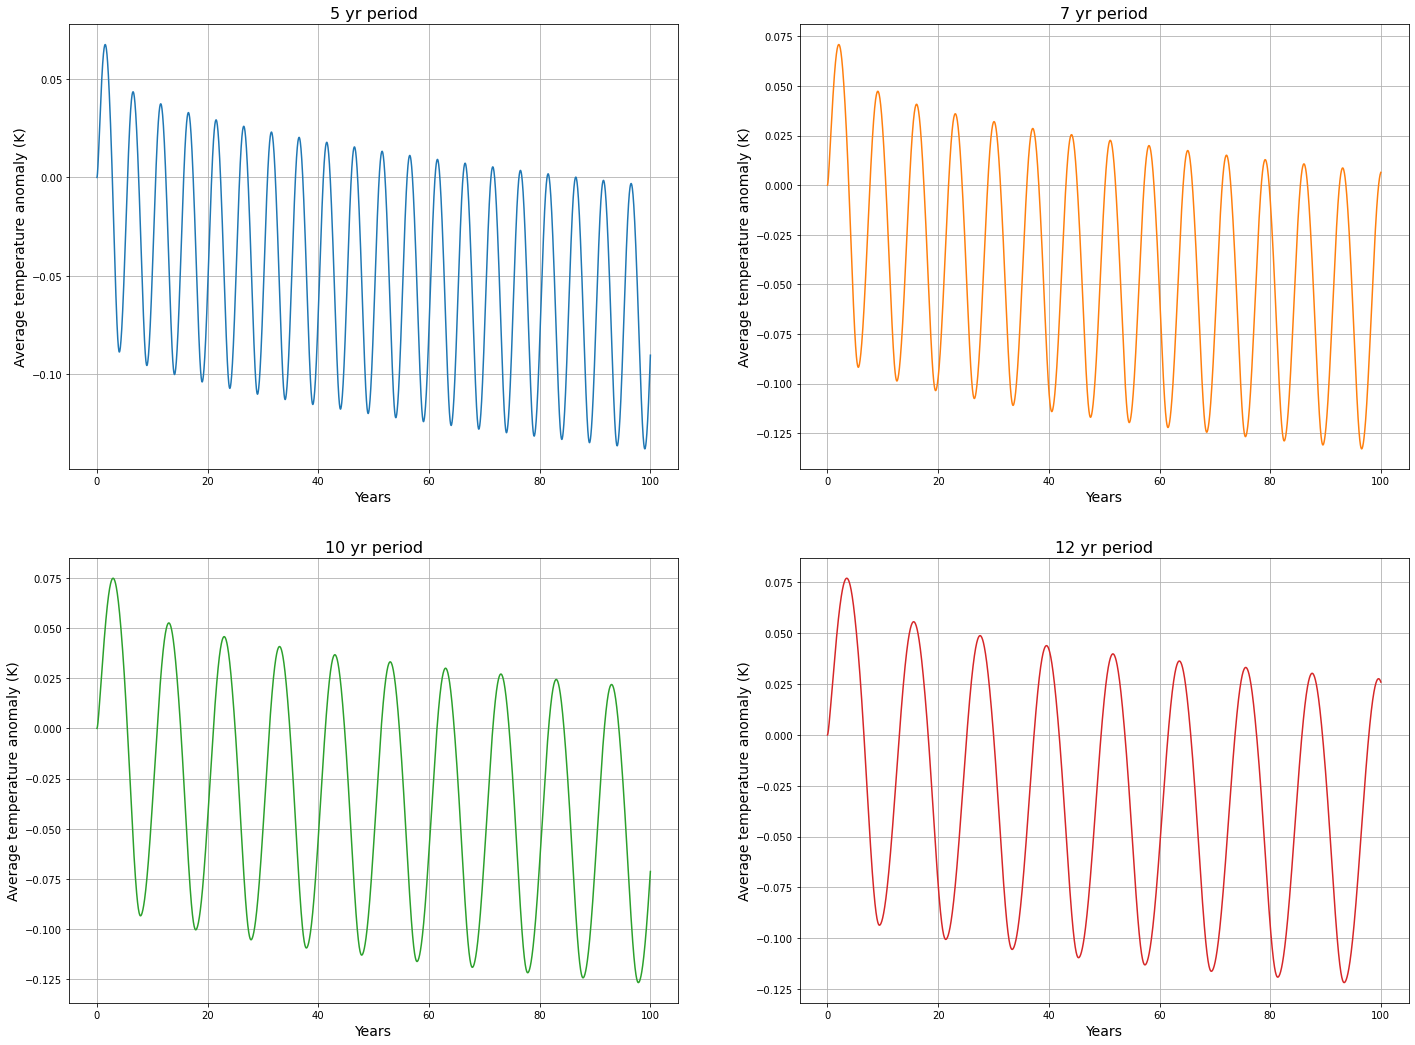

In [27]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(24, 18))
OHCs = [OHC_A1_P2, OHC_A1_P5, OHC_A1_P7, OHC_A1_P10, OHC_A1_P12, OHC_A1_P16, OHC_A1_P20]
names = ['2 yr period', '5 yr period', '7 yr period', '10 yr period', '12 yr period', \
         '16 yr period', '20 yr period']
colors = ['C0', 'C1', 'C2', 'C3']

for i, ax in enumerate(axs.flatten()):
    j = i + 1
    ax.plot(time_years, OHCs[j] - OHC_cont, color = colors[i])
    ax.set_title(names[j], fontsize=16)
    ax.set_xlabel('Years', fontsize=14)
    ax.set_ylabel('Average temperature anomaly (K)', fontsize=14)
    ax.grid()

In [281]:
# Calculate linear trend

def line(t, a, b):
    return a * t + b

days_in_year = 360

popt, pcov = curve_fit(line, t, OHC_A1_P2 - OHC_cont)
OHC_A1_P2_trend = line(t, *popt)
m2 = popt[0]
# print(f'OHC trend for sinusoidal forcing with 2 year period over 160 years is {popt[0] * days_in_year} Jm-2/year')
# print(f'Net OHC drift for sinusoidal forcing with 2 year period over 160 years is {popt[0] * days_in_year * years} Jm-2')
# print('')
print(f'Temperature trend for sinusoidal forcing with 2 year period over 160 years is {round(m2 * days_in_year * 1e3, 2)} mK/year')
print(f'Net temperature drift for sinusoidal forcing with 2 year period over 160 years is {round(m2 * days_in_year * years, 2)} K')
print('')

popt, pcov = curve_fit(line, t, OHC_A1_P5 - OHC_cont)
OHC_A1_P5_trend = line(t, *popt)
m5 = popt[0]
# print(f'OHC trend for sinusoidal forcing with 5 year period over 160 years is {popt[0] * days_in_year * SA_ocean} J/year')
# print(f'Net OHC drift for sinusoidal forcing with 5 year period over 160 years is {popt[0] * days_in_year * SA_ocean * years} J')
# print('')
print(f'Temperature trend for sinusoidal forcing with 5 year period over 160 years is {round(m5 * days_in_year * 1e3, 2)} mK/year')
print(f'Net temperature drift for sinusoidal forcing with 5 year period over 160 years is {round(m5 * days_in_year * years, 2)} K')
print('')

popt, pcov = curve_fit(line, t, OHC_A1_P20 - OHC_cont)
OHC_A1_P20_trend = line(t, *popt)
m20 = popt[0]
# print(f'OHC trend for sinusoidal forcing with 20 year period over 160 years is {popt[0] * days_in_year * SA_ocean} J/year')
# print(f'Net OHC drift for sinusoidal forcing with 20 year period over 160 years is {popt[0] * days_in_year * SA_ocean * years} J')
# print('')
print(f'Temperature trend for sinusoidal forcing with 20 year period over 160 years is {round(m20 * days_in_year * 1e3, 2)} mK/year')
print(f'Net temperature drift for sinusoidal forcing with 20 year period over 160 years is {round(m20 * days_in_year * years, 2)} K')
print('')

popt, pcov = curve_fit(line, t, OHC_A1_P40 - OHC_cont)
OHC_A1_P40_trend = line(t, *popt)
m40 = popt[0]
# print(f'OHC trend for sinusoidal forcing with 40 year period over 160 years is {popt[0] * days_in_year * SA_ocean} J/year')
# print(f'Net OHC drift for sinusoidal forcing with 40 year period over 160 years is {popt[0] * days_in_year * SA_ocean * years} J')
# print('')
print(f'Temperature trend for sinusoidal forcing with 40 year period over 160 years is {round(m40 * days_in_year * 1e3, 2)} mK/year')
print(f'Net temperature drift for sinusoidal forcing with 40 year period over 160 years is {round(m40 * days_in_year * years, 2)} K')
print('')

Temperature trend for sinusoidal forcing with 2 year period over 160 years is -0.15 mK/year
Net temperature drift for sinusoidal forcing with 2 year period over 160 years is -0.02 K

Temperature trend for sinusoidal forcing with 5 year period over 160 years is -0.21 mK/year
Net temperature drift for sinusoidal forcing with 5 year period over 160 years is -0.03 K

Temperature trend for sinusoidal forcing with 20 year period over 160 years is -0.33 mK/year
Net temperature drift for sinusoidal forcing with 20 year period over 160 years is -0.05 K

Temperature trend for sinusoidal forcing with 40 year period over 160 years is -0.44 mK/year
Net temperature drift for sinusoidal forcing with 40 year period over 160 years is -0.07 K



In [ ]:
#Plot

#fig = plt.figure(figsize=(18,8))
# plt.plot(time_years, OHC_A1_P2 - OHC_cont, label='2 yr', color = 'b')
# plt.plot(time_years, OHC_A1_P5 - OHC_cont, label='5 yr', color = 'r')
# plt.plot(time_years, OHC_A1_P20 - OHC_cont, label='20 yr', color = 'g')
# plt.plot(time_years, OHC_A1_P40 - OHC_cont, label='40 yr', color = 'k')
# plt.plot(time_years, OHC_A1_P2_trend, label='2 yr', color = 'purple', linestyle = ':')
# plt.plot(time_years, OHC_A1_P5_trend, label='5 yr', color = 'brown', linestyle = ':')
# plt.plot(time_years, OHC_A1_P20_trend, label='20 yr', color = 'pink', linestyle = ':')
# plt.plot(time_years, OHC_A1_P40_trend, label='40 yr', color = 'gray', linestyle = ':')
# plt.xlabel('Years', fontsize=12)
# plt.ylabel('Temperature anomaly (K)', fontsize=12)
# plt.title('Average temperature anomaly')
# plt.grid()
# plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(1, 0.5),loc = 'center left')

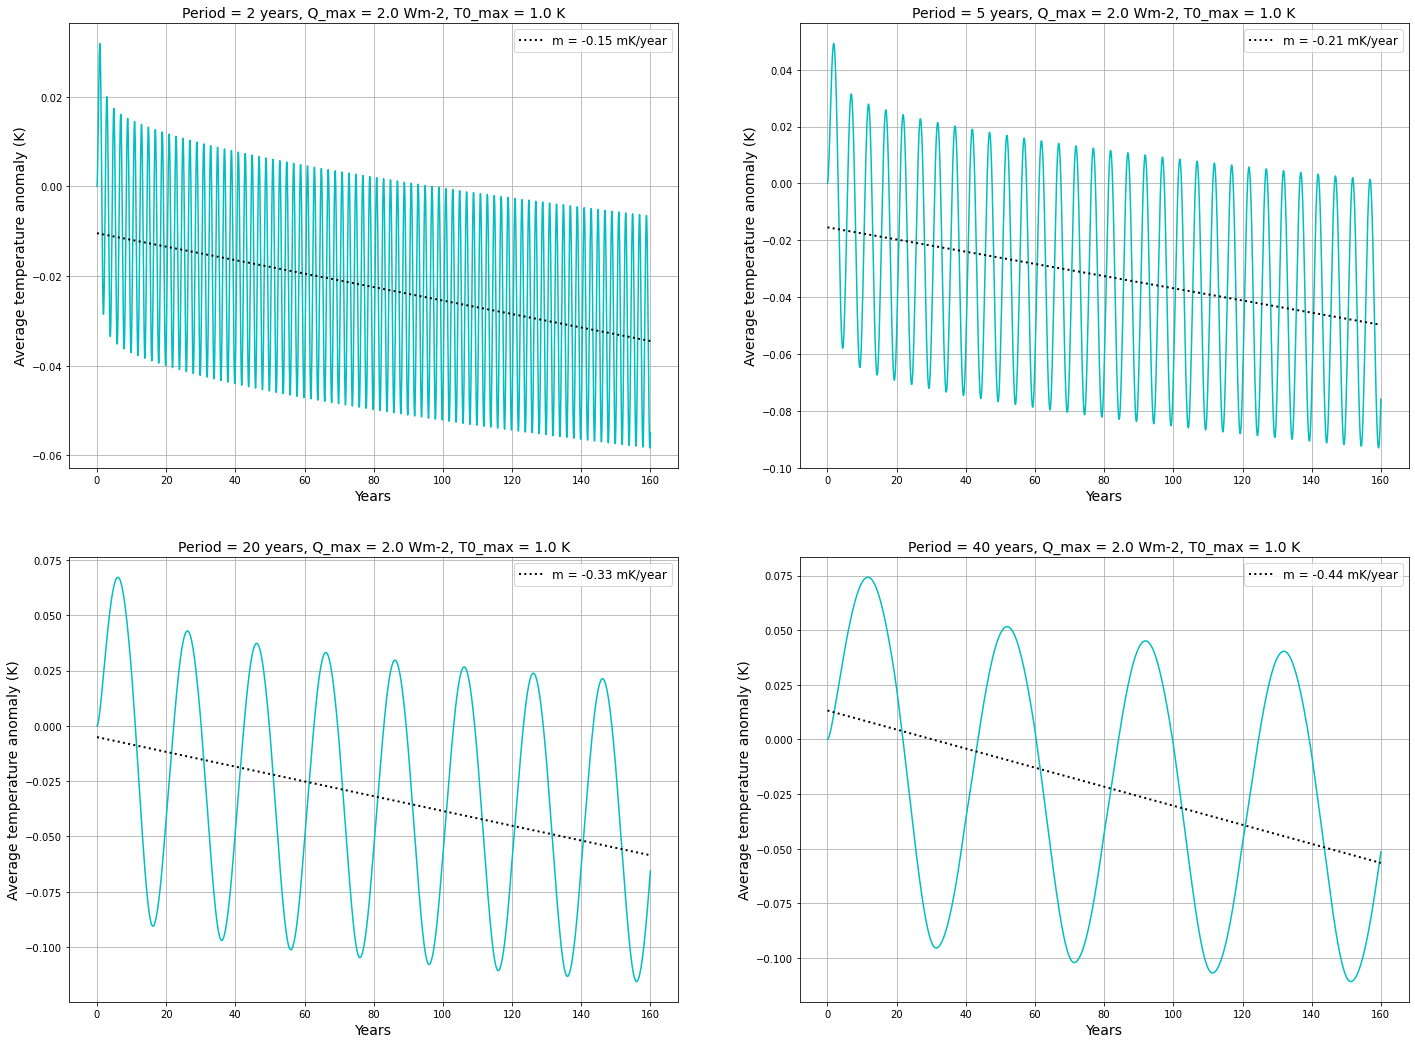

In [253]:
### Plot

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(24, 18))
axs[0, 0].plot(time_years, OHC_A1_P2 - OHC_cont, color = 'c')
axs[0, 0].plot(time_years, OHC_A1_P2_trend, label=f'm = {round(m2 * days_in_year * 1e3, 2)} mK/year', color = 'k', linestyle = ':', linewidth = 2.0)
axs[0, 0].set_xlabel('Years', fontsize=14)
axs[0, 0].set_ylabel('Average temperature anomaly (K)', fontsize=14)
axs[0, 0].set_title('Period = 2 years, Q_max = 2.0 Wm-2, T0_max = 1.0 K', fontsize=14)
axs[0, 0].grid()
axs[0, 0].legend(fontsize=12)

axs[0, 1].plot(time_years, OHC_A1_P5 - OHC_cont, color = 'c')
axs[0, 1].plot(time_years, OHC_A1_P5_trend, label=f'm = {round(m5 * days_in_year * 1e3, 2)} mK/year', color = 'k', linestyle = ':', linewidth = 2.0)
axs[0, 1].set_xlabel('Years', fontsize=14)
axs[0, 1].set_ylabel('Average temperature anomaly (K)', fontsize=14)
axs[0, 1].set_title('Period = 5 years, Q_max = 2.0 Wm-2, T0_max = 1.0 K', fontsize=14)
axs[0, 1].grid()
axs[0, 1].legend(fontsize=12)

axs[1, 0].plot(time_years, OHC_A1_P20 - OHC_cont, color = 'c')
axs[1, 0].plot(time_years, OHC_A1_P20_trend, label=f'm = {round(m20 * days_in_year * 1e3, 2)} mK/year', color = 'k', linestyle = ':', linewidth = 2.0)
axs[1, 0].set_xlabel('Years', fontsize=14)
axs[1, 0].set_ylabel('Average temperature anomaly (K)', fontsize=14)
axs[1, 0].set_title('Period = 20 years, Q_max = 2.0 Wm-2, T0_max = 1.0 K', fontsize=14)
axs[1, 0].grid()
axs[1, 0].legend(fontsize=12)

axs[1, 1].plot(time_years, OHC_A1_P40 - OHC_cont, color = 'c')
axs[1, 1].plot(time_years, OHC_A1_P40_trend, label=f'm = {round(m40 * days_in_year * 1e3, 2)} mK/year', color = 'k', linestyle = ':', linewidth = 2.0)
axs[1, 1].set_xlabel('Years', fontsize=14)
axs[1, 1].set_ylabel('Average temperature anomaly (K)', fontsize=14)
axs[1, 1].set_title('Period = 40 years, Q_max = 2.0 Wm-2, T0_max = 1.0 K', fontsize=14)
axs[1, 1].grid()
axs[1, 1].legend(fontsize=12)
plt.savefig('sinusoidal_diff_frequencies.jpg')

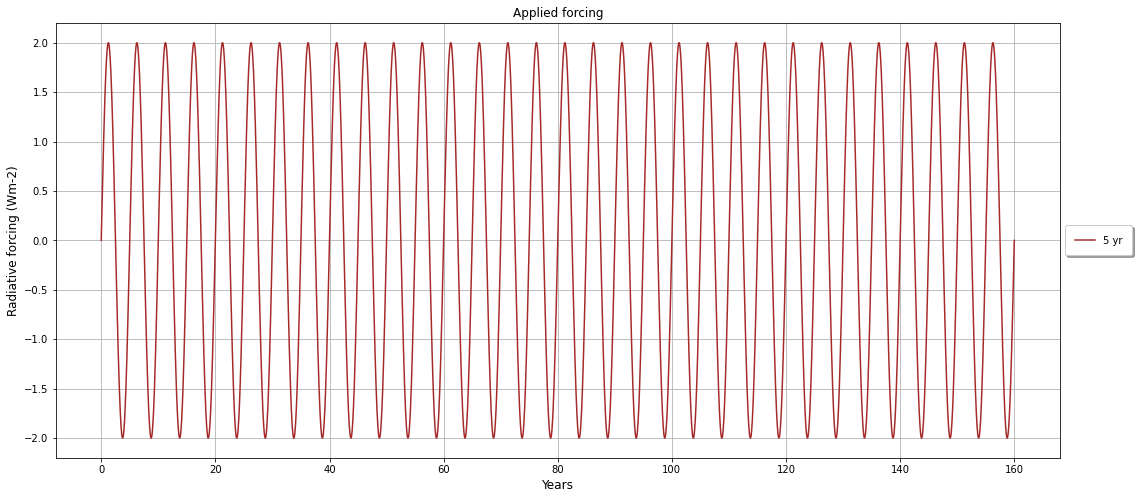

In [282]:
#Plot

fig = plt.figure(figsize=(18,8))

#plt.plot(time_years, forcing_Q2_P2, label='2 yr', color = 'purple')
plt.plot(time_years, forcing_Q2_P5, label='5 yr', color = 'brown')
# plt.plot(time_years, forcing_Q2_P20, label='20 yr', color = 'pink')
#plt.plot(time_years, forcing_Q2_P40, label='40 yr', color = 'gray')

plt.xlabel('Years', fontsize=12)
plt.ylabel('Radiative forcing (Wm-2)', fontsize=12)
plt.title('Applied forcing')
plt.grid()
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(1, 0.5),loc = 'center left')

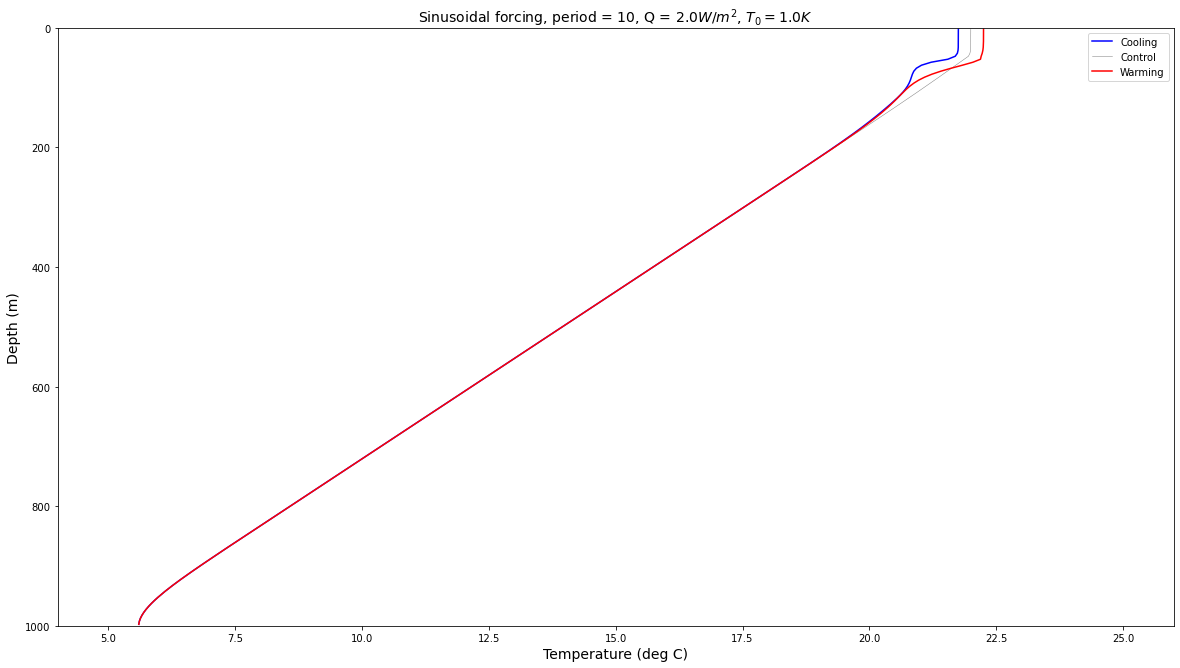

In [99]:
### Animate

### Eventually I would like a counter that reads how many years & days we are at: e.g., Year 0, day 10; Year 0, day 20, ...; Year 0 day 360; Year 1 day 10  

fig = plt.figure(figsize=(20, 11))
ax = plt.axes(xlim=(4, 26), ylim=(z[0], z[-1]))
line1, = ax.plot([], [], color = 'b', label = 'Cooling')
# line2, = ax.plot([], [], color = 'gray', label = 'Control', linewidth = 0.5)
# line3, = ax.plot([], [], color = 'r', label = 'Warming')

def init():
    line.set_data([], [])
    return line,

def animate(i):
    line1.set_data(cw_expt[:, i], z_t)
    #line2.set_data(control_expt[:, i], z_t)
    #line3.set_data(wc_expt[:, i], z_t)
    return line1,# line2, line3

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(warm[0, :]), interval=50, blit=True)

title = 'Sinusoidal forcing, period = 20 yr, Q = $2.0$ W$/m^2$, $T_0 = 1.0$ C'

ax.set_title(title, fontsize = 14)
ax.set_xlabel('Temperature (deg C)', fontsize = 14)
ax.set_ylabel('Depth (m)', fontsize = 14)
ax.invert_yaxis()
ax.legend()

anim.save('sinusoidal_period20.mp4')